# Urbanization <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">

* **Products used:** 
[ls8_usgs_sr_scene](https://explorer.digitalearth.africa/ls8_usgs_sr_scene)


## Background

Urban areas, human settlement

impacts agriculture, water, natural environment etc

## Description

This notebook addressess the calculation of land consumption rate (urbanization) using **Normalized Differential Built Index (NDBI)** and  **Normalized Differential Vegetation Index (NDVI)**. 
This notebook makes use of **Dask** for parrallel processing and **Geomedian composites** in combining and procesing of the landsat images for the two different years. Also the calculate band indicies function was used in calculating the **NDBI, NDVI, BI**.

This notebook demonstrates how to:

1. Enabling Dask and the Dask Dashboard.
2. Loading data with Dask in chunks.
3. Generate the Geomedian composite for the two different years.
4. Calculate urbanization indices using the Calculate Band Indices function.
5. Plotting a histogram of the two year for the built up areas.

***

## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.  

### Load packages
Import Python packages that are used for the analysis.

In [16]:
%matplotlib inline

import datacube
import numpy as np
import matplotlib.pyplot as plt
from odc.ui import with_ui_cbk
import odc.algo
from odc.algo import to_f32, from_float, xr_geomedian, reshape_for_geomedian
import xarray as xr

import sys
sys.path.append('../Scripts')

import warnings
warnings.filterwarnings("ignore")

from deafrica_datahandling import load_ard, mostcommon_crs  #, calc_geomedian
from deafrica_plotting import display_map, rgb
from deafrica_bandindices import calculate_indices
from deafrica_dask import create_local_dask_cluster

## Load Landsat 8 data from the datacube

Here we are loading in a timeseries of `Landsat 8` satellite images through the datacube API.
This will provide us with some data to work with.

In [17]:
dc = datacube.Datacube(app='DEA_urbanization')

In [18]:
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:41797 Dashboard: /user/ahicks/proxy/38851/status,Cluster Workers: 1 Cores: 2 Memory: 14.18 GB


In [108]:
#Alter the lat and lon to suit your stude area
lat, lon = 6.6724, -1.6070

#Provide your area of extent here
buffer = 0.15

#Change the years values also here
#Note: landsat 8 starts from 2013
first_year = 2015
second_year = 2019

In [109]:
# Create a reusable query
# Use lower-res
query = {
    'time': (f'{first_year}', f'{second_year}'),
    'x': (lon-buffer, lon+buffer),
    'y': (lat+buffer, lat-buffer),
    'group_by': 'solar_day',
    'resolution': (-60, 60),
    'align': (15, 15)
}

In [110]:
#Display area of interest
display_map(query['x'], query['y'])

In [111]:
#Determine the most common used CRS for the product
output_crs = mostcommon_crs(dc=dc, product='ls8_usgs_sr_scene', query=query)

The `calc_geomedian` function to be added by [PR #112](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks/pull/112):

In [112]:
def calc_geomedian(ds, 
                   axis="time", 
                   max_value=None, 
                   min_value=None,
                   num_threads=1, 
                   eps=1e-7, 
                   nocheck=True):
    '''
    Runs geomedian over a xarray.Dataset or xarray.DataArray.
    
    Specify min_value and max_value if known for better performance, 
    especially if using dask.
    
    Parameters
    ----------
    da : xarray.DataArray object
    max_value : the maximum value that could be found in the array
    min_value : the minimum value that could be found in the array
    '''
    da = odc.algo.reshape_for_geomedian(ds, axis=axis) if isinstance(ds, xr.Dataset) else ds

    if max_value is None:
        max_value = da.max(skipna=True)
    if min_value is None:
        min_value = da.min(skipna=True)

    offset = min_value
    scale = max_value - min_value

    da_scaled = odc.algo.to_f32(da, scale=(1 / scale), offset=(-offset / scale))

    geomedian = odc.algo.xr_geomedian(da_scaled, num_threads=num_threads, eps=eps, nocheck=nocheck)

    geomedian = odc.algo.from_float(
        geomedian,
        dtype=da.dtype,
        nodata=np.nan,
        scale=scale,
        offset=offset,
    )

    if isinstance(ds, xr.Dataset):
        geomedian = geomedian.to_dataset(dim='band')

    return geomedian

In [113]:
ds = load_ard(
    dc=dc, 
    products=['ls8_usgs_sr_scene'],
    output_crs=output_crs,
    dask_chunks={'time': 1, 'x': 500, 'y': 500},
    **query
)

Using pixel quality parameters for USGS Collection 1
Finding datasets
    ls8_usgs_sr_scene
Applying pixel quality/cloud mask
Returning 98 time steps as a dask array


### Calculate the geomedian for each year

In [114]:
# change the data into an array so it can be used with `map`
da = reshape_for_geomedian(ds)

# groupby year, then calculate the geomedian on each year
# For Landsat c1, the max_value is 10,000
geomedian_da = da.groupby('time.year').map(calc_geomedian, min_value=0, max_value=10000)

# Change back into a xr.Dataset
geomedian_all_years = geomedian_da.to_dataset(dim='band')
geomedian_all_years

<xarray.Dataset>
Dimensions:          (x: 555, y: 555, year: 4)
Coordinates:
  * x                (x) float64 6.374e+05 6.374e+05 ... 6.705e+05 6.706e+05
  * y                (y) float64 7.544e+05 7.543e+05 ... 7.212e+05 7.211e+05
  * year             (year) int64 2015 2016 2017 2019
Data variables:
    coastal_aerosol  (y, x, year) float32 dask.array<chunksize=(500, 500, 1), meta=np.ndarray>
    blue             (y, x, year) float32 dask.array<chunksize=(500, 500, 1), meta=np.ndarray>
    green            (y, x, year) float32 dask.array<chunksize=(500, 500, 1), meta=np.ndarray>
    red              (y, x, year) float32 dask.array<chunksize=(500, 500, 1), meta=np.ndarray>
    nir              (y, x, year) float32 dask.array<chunksize=(500, 500, 1), meta=np.ndarray>
    swir1            (y, x, year) float32 dask.array<chunksize=(500, 500, 1), meta=np.ndarray>
    swir2            (y, x, year) float32 dask.array<chunksize=(500, 500, 1), meta=np.ndarray>
    sr_aerosol       (y, x, year) float32 dask.array<chunksize=(500, 500, 1), meta=np.ndarray>
    radsat_qa        (y, x, year) float32 dask.array<chunksize=(500, 500, 1), meta=np.ndarray>
Attributes:
    crs:           epsg:32630
    grid_mapping:  spatial_ref
    nodata:        nan

We can see now that the `time` dimension has been replaced by the `year` dimension. Since the query was for alll data between our target years, we have data for all years in the range.  Since we are only looking at 2 years, we will just select those.

As we are using `dask`, no data reading or calculations have yet taken place.

In [115]:
year_list = [first_year, second_year]
geomedian_sel = geomedian_all_years.sel(year=year_list)
geomedian_sel

<xarray.Dataset>
Dimensions:          (x: 555, y: 555, year: 2)
Coordinates:
  * x                (x) float64 6.374e+05 6.374e+05 ... 6.705e+05 6.706e+05
  * y                (y) float64 7.544e+05 7.543e+05 ... 7.212e+05 7.211e+05
  * year             (year) int64 2015 2019
Data variables:
    coastal_aerosol  (y, x, year) float32 dask.array<chunksize=(500, 500, 1), meta=np.ndarray>
    blue             (y, x, year) float32 dask.array<chunksize=(500, 500, 1), meta=np.ndarray>
    green            (y, x, year) float32 dask.array<chunksize=(500, 500, 1), meta=np.ndarray>
    red              (y, x, year) float32 dask.array<chunksize=(500, 500, 1), meta=np.ndarray>
    nir              (y, x, year) float32 dask.array<chunksize=(500, 500, 1), meta=np.ndarray>
    swir1            (y, x, year) float32 dask.array<chunksize=(500, 500, 1), meta=np.ndarray>
    swir2            (y, x, year) float32 dask.array<chunksize=(500, 500, 1), meta=np.ndarray>
    sr_aerosol       (y, x, year) float32 dask.array<chunksize=(500, 500, 1), meta=np.ndarray>
    radsat_qa        (y, x, year) float32 dask.array<chunksize=(500, 500, 1), meta=np.ndarray>
Attributes:
    crs:           epsg:32630
    grid_mapping:  spatial_ref
    nodata:        nan

#### Load the data and calculate the geomedian for the selected years

In [116]:
%%time
geomedian_sel.load()

CPU times: user 5.48 s, sys: 309 ms, total: 5.79 s
Wall time: 58.3 s


<xarray.Dataset>
Dimensions:          (x: 555, y: 555, year: 2)
Coordinates:
  * x                (x) float64 6.374e+05 6.374e+05 ... 6.705e+05 6.706e+05
  * y                (y) float64 7.544e+05 7.543e+05 ... 7.212e+05 7.211e+05
  * year             (year) int64 2015 2019
Data variables:
    coastal_aerosol  (y, x, year) float32 360.00162 346.18597 ... 242.42244
    blue             (y, x, year) float32 529.00073 470.08643 ... 352.9282
    green            (y, x, year) float32 925.9995 807.2778 ... 646.49133
    red              (y, x, year) float32 952.9991 841.8589 ... 501.81274
    nir              (y, x, year) float32 3171.9985 2847.7476 ... 3351.9424
    swir1            (y, x, year) float32 2424.0 2229.7766 ... 1856.9124
    swir2            (y, x, year) float32 1544.9991 1419.9408 ... 916.73956
    sr_aerosol       (y, x, year) float32 220.99931 159.88667 ... 170.97742
    radsat_qa        (y, x, year) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    crs:           epsg:32630
    grid_mapping:  spatial_ref
    nodata:        nan

We can plot the two years to visually compare them:

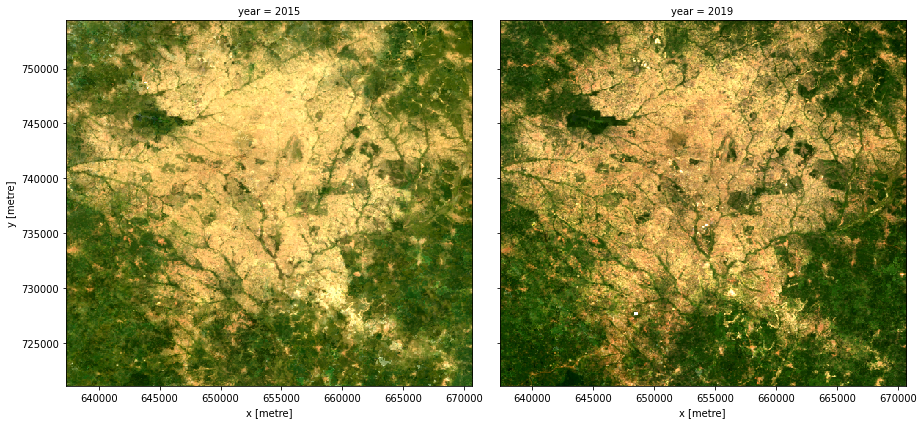

In [117]:
rgb(geomedian_sel, col='year')

## Calculating the indices

There are a number of ways to measure urbanization.
This notebook follows the approach by [He et al.](https://www.tandfonline.com/doi/pdf/10.1080/01431161.2010.481681), which combines the normalized difference built-up index (NDBI) and the normalized difference vegetation index (NDVI) to calculate built-up index (BU) as

$$ \text{BU} = \text{NDBI} - \text{NDVI},$$

where

$$\text{NDBI} = \frac{\text{SWIR} - \text{NIR}}{\text{SWIR} - \text{NIR}},$$

$$\text{NDVI} = \frac{\text{NIR} - \text{Red}}{\text{NIR} - \text{Red}}.$$

The intuition being that urban areas will have high NDBI and low NDVI, corresponding to high BU, whereas vegetated areas will have low NDBI and high NDVI, corresponding to low BU. 

In [118]:
# Calculate BU Index, as well as NDVI and NDBI, using the formulas above
geomedian_with_indices = calculate_indices(geomedian_sel, index=['NDVI', 'NDBI', 'BUI'], collection = 'c1')

#### Normalised Difference Built-up Index (NDBI)

We will first look at the built-up index.  This is in the range of 1 to -1.

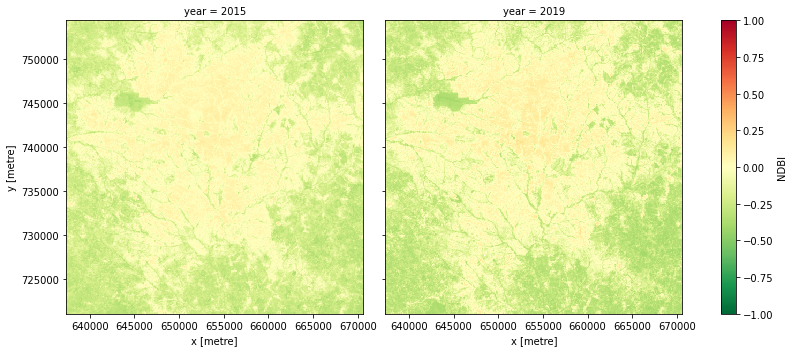

In [119]:
geomedian_with_indices.NDBI.plot(
    col='year',
    vmin=-1, 
    vmax=1, 
    cmap='RdYlGn_r',
    figsize=(12, 5),
    robust=True
);

Here we find the NDBI is not very strong, but we can adjust the plot to better show the built area.

We can ignore values below 0, and change the colour map so that smaller values are easier to see:

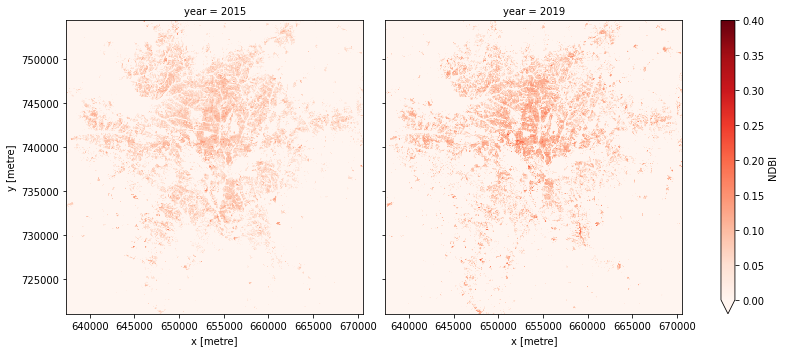

In [120]:
geomedian_with_indices.NDBI.plot(
    col='year',
    vmin=0, 
    vmax=0.4, 
    cmap='Reds',
    figsize=(12, 5),
    robust=True
);

#### Normalized Difference Vegetation Index (NDVI)

To find vegetated areas, we use NDVI. It is in the range 1 (high vegitation signal) to -1 (high non-vegetation signal).

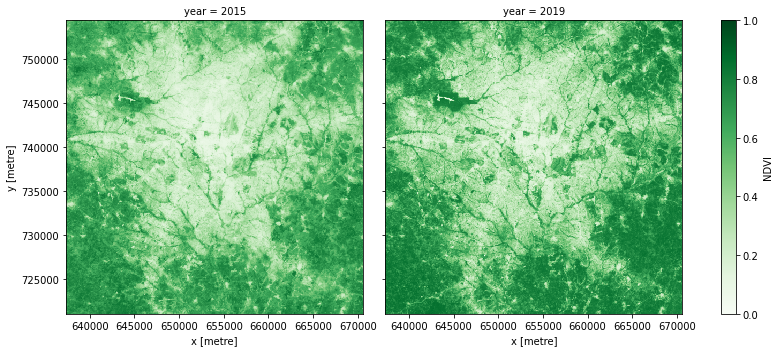

In [121]:
geomedian_with_indices.NDVI.plot(
    col='year',
    vmin=0, 
    vmax=1, 
    cmap='Greens',
    figsize=(12, 5),
    robust=True
);

#### Built-Up Index (BUI)

As we can see above, built up areas tend to have low vegetation, and areas of high vegetation tend to have a low NDBI value.

The Built-Up Index amplifies this effect.

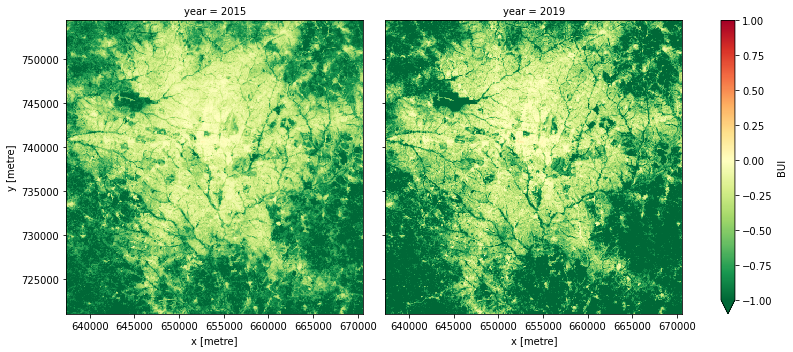

In [122]:
geomedian_with_indices.BUI.plot(
    col='year',
    vmin=-1, 
    vmax=1, 
    cmap='RdYlGn_r',
    figsize=(12, 5),
    robust=True
);

## Calculate the urban area

Again we see that the effect is not very strong, so we can adjust the color values.

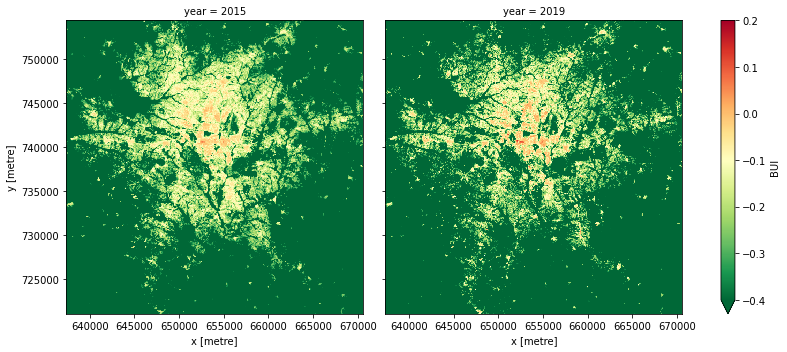

In [123]:
geomedian_with_indices.BUI.plot(
    col='year',
    vmin=-0.4, 
    vmax=0.2, 
    cmap='RdYlGn_r',
    figsize=(12, 5),
    robust=True
);

For the given built-up index, we need a method to decide whether a pixel is considered as "urban".
If there was classification label data available, it might be possible to train a machine learning algorithm to directly identify pixels as urban or not.
Without these labels, we can do a simple threshold to specify that pixels with BU values above the threshold are urban.
Based on the image above, we specify a threshold of $\text{BU} \geq -0.2$.
> **Note:** You may wish to experiment with the threshold value by changing it below. 
Examine the plot above to choose reasonable values.

Once the threshold is defined, the cell below classifies pixels as urban (value of 1) or non-urban (value of 0).

In [175]:
year_threshold = xr.DataArray([-0.25, -0.3], coords=[('year', [2015, 2019])])

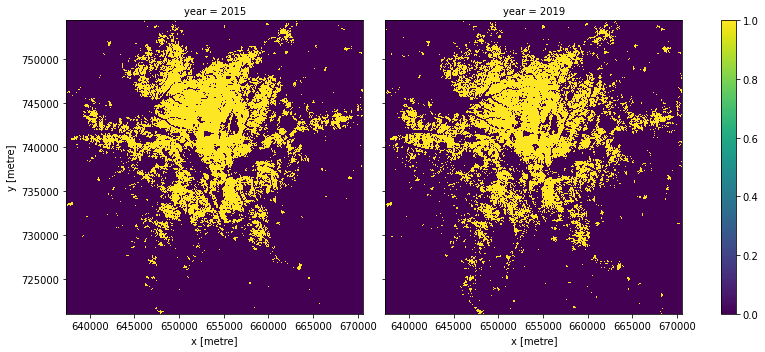

In [176]:
urban_area = (geomedian_with_indices.BUI > year_threshold).astype(int)
urban_area.plot(
    col='year',
    figsize=(12, 5),
    robust=True
);

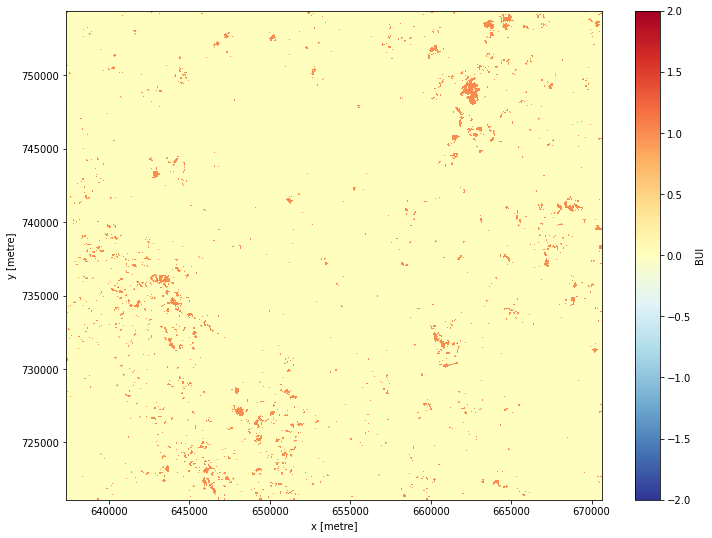

In [177]:
bui_change = geomedian_with_indices.BUI.sel(year=second_year) - geomedian_with_indices.BUI.sel(year=first_year)
(bui_change > 0.25).plot(
    cmap='RdYlBu_r',
    figsize=(12, 9),
    vmin=-2,
    vmax=2,
);

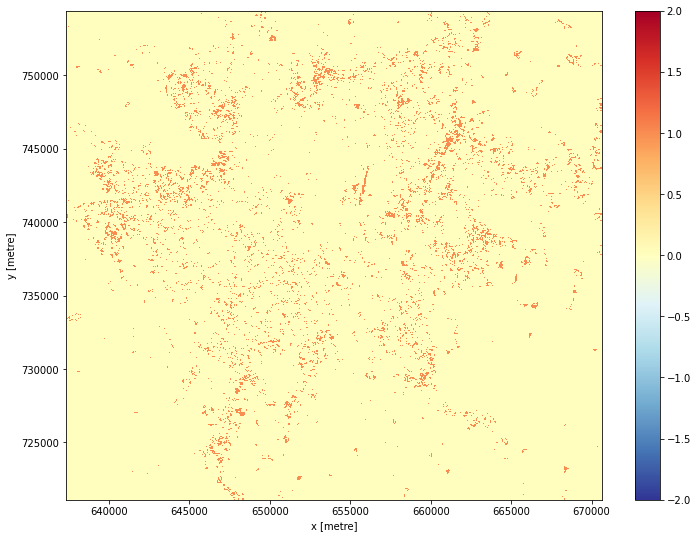

In [181]:
urban_change = urban_area.sel(year=second_year) - urban_area.sel(year=first_year)
(urban_change > 0).plot(
    cmap='RdYlBu_r',
    figsize=(12, 9),
    vmin=-2,
    vmax=2,
);

In [188]:
pixel_length = query["resolution"][1]  # in metres
m_per_km = 1000  # conversion from metres to kilometres
area_per_pixel = pixel_length**2 / m_per_km**2

urban_area_km2 = urban_area.sum(dim=['x', 'y']) * area_per_pixel

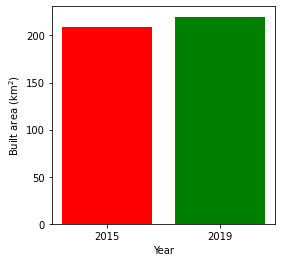

In [190]:
# Plot the resulting area through time
fig, axes = plt.subplots(1, 1, figsize=(4, 4))
plt.bar([0, 1], 
        urban_area_km2, 
        tick_label = urban_area_km2.year, 
        width = 0.8, 
        color = ['red', 'green'])
axes.set_xlabel("Year")
axes.set_ylabel("Built area (km$^2$)")
plt.show()

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Last modified:** April 2020

**Compatible datacube version:** 

In [25]:
print(datacube.__version__)

1.8.0b7.dev35+g5023dada


## Tags
Browse all available tags on the DE Africa User Guide's [Tags Index](https://) (placeholder as this does not exist yet)